# PyTorch UNet with TGS Salt Dataset

This is a heavily modifited example from the link in 2.

1. Original UNet paper: https://arxiv.org/pdf/1505.04597.pdf

2. Segmentation example notebook with pets: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

In [1]:
import os

import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

# Scikit-learn
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Image handeling imports 
from PIL import Image

import skimage # scikit-image
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

## Loading Watermark
from watermark import watermark
%load_ext watermark

In [2]:
# PyTorch specific imports
import torch
import torchvision
import torch.nn as nn

import segmentation_models_pytorch as smp

import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

GPU Check

In [3]:
print('PyTorch CUDA check, GPU is enabled:', torch.cuda.is_available())
print('How many GPU\'s?', torch.cuda.device_count())

PyTorch CUDA check, GPU is enabled: True
How many GPU's? 1


In [4]:
%watermark --iversions

sklearn                    : 0.0.post1
numpy                      : 1.23.5
skimage                    : 0.19.3
segmentation_models_pytorch: 0.3.1
pytorch_lightning          : 1.8.5.post0
PIL                        : 9.3.0
matplotlib                 : 3.6.2
torch                      : 1.13.0
torchvision                : 0.14.0
re                         : 2.2.1



### Directory specific variables:

The TGS Kaggle dataset has specific licensing that I can't link directly to the images itself. Follow the instructions in the link below:

https://www.kaggle.com/competitions/tgs-salt-identification-challenge/data

In [5]:
train_image = 'competition_data/train/images/'
train_mask = 'competition_data/train/masks/'

file_list_image = glob.glob(train_image + "/*.png")
file_list_mask = glob.glob(train_mask + "/*.png")

Make a list of all the png's using grep:

In [6]:
png_filenames = []

for q in range(len(file_list_image)):
    k = re.split("/", file_list_image[q], maxsplit=5)[3]
    png_filenames.append(k)
    
print('Number of images:', len(png_filenames))

Number of images: 4000


#### Getting random splits of the image dataset:

In [7]:
n_train = int(.8*len(png_filenames))
print('number of training images:', n_train)

n_test = int(.15*len(png_filenames))
print('number of testing images:', n_test)

n_val = int(.05*len(png_filenames))
print('number of validation images:', n_val)

number of training images: 3200
number of testing images: 600
number of validation images: 200


Splitting up the dataset 

In [8]:
# want to keep png_filenames clean
_pngs = png_filenames

# training data
train_fn = random.sample(_pngs, n_train)
print('number of training images:', len(train_fn))

# want to make sure we are not pulling from the training data for our testing data
no_training = [i for n, i in enumerate(_pngs) if i not in train_fn] 
test_fn = random.sample(no_training, n_test)
print('number of testing images:', len(test_fn))

# remaining iamges are the validation dataset
no_training_testing = [i for n, i in enumerate(no_training) if i not in test_fn] 

val_fn = no_training_testing
print('number of validationimages:', len(val_fn))


number of training images: 3200
number of testing images: 600
number of validationimages: 200


#### Functions to pre-process the dataset, and make into a dictionary

In [9]:
def _preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask 

In [10]:
class DatasetGrab(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}
        # print('Mode is:', mode)
        
        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = train_image
        self.masks_directory = train_mask

        
        if self.mode == "train":  
            self.filenames = train_fn
        elif self.mode == "test": 
            self.filenames  = test_fn
        elif self.mode == "valid":  
            self.filenames  = val_fn
        
    def __len__(self):      
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # print(self.mode)
       
        filename = self.filenames[idx]
        
        # paths
        image_path = os.path.join(self.images_directory, filename)
        mask_path = os.path.join(self.masks_directory, filename)

        # data
        #image = np.array(Image.open(image_path).convert("RGB"))
        img = io.imread(image_path)
        
        # if we want to convert to grayscale
        #image = rgb2gray(img[:,:,:3])
        #image = np.expand_dims(image, axis=0)
        image = img[:,:,:3]
        
        mask = np.array(io.imread(mask_path))
        scaler = MinMaxScaler()
        
        mask = scaler.fit_transform(mask, y=None)

        
        trimap = _preprocess_mask(mask)

        sample = dict(image=image, mask=mask, trimap=trimap)
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample
    

class SaltTGSDataset(DatasetGrab):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images using PIL
        image = np.array(Image.fromarray(sample["image"]).resize((256, 256), Image.Resampling.BILINEAR))
        
        mask = np.array(Image.fromarray(sample["mask"]).resize((256, 256), Image.Resampling.NEAREST))
        
        trimap = np.array(Image.fromarray(sample["trimap"]).resize((256, 256), Image.Resampling.NEAREST))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

Let's run some of this stuff!

In [11]:
root = "."

# init train, val, test sets

train_dataset = SaltTGSDataset(root, mode="train")
valid_dataset = SaltTGSDataset(root, mode="valid")
test_dataset  = SaltTGSDataset(root, mode="test")

# these should be different sizes
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 3200
Valid size: 200
Test size: 600


In [12]:
# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=n_cpu)

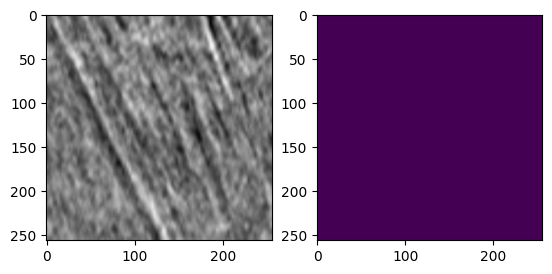

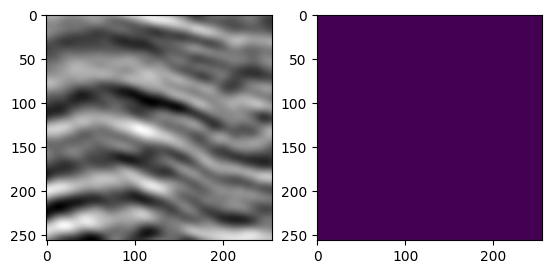

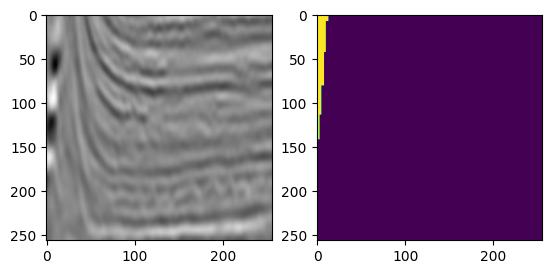

In [13]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1,2,0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[3]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1,2,0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[6]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1,2,0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

# Deep Learning Model Definition

In [14]:
class SaltModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [15]:
model = SaltModel("FPN", "resnet34", in_channels=3, out_classes=1)

In [16]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=15,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Note: I didn't find much improvement moving beyond 10-15 epochs

### Run it!

In [17]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [18]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_per_image_iou': 0.7547850608825684, 'valid_dataset_iou': 0.7577183246612549}]


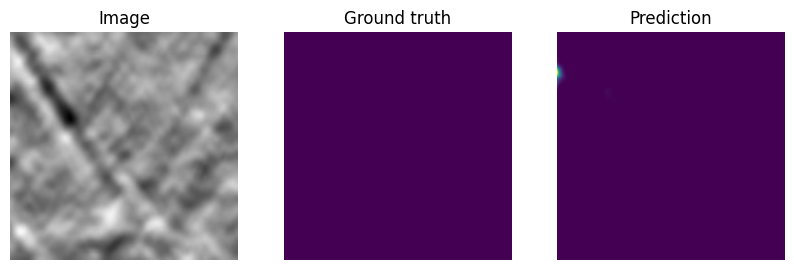

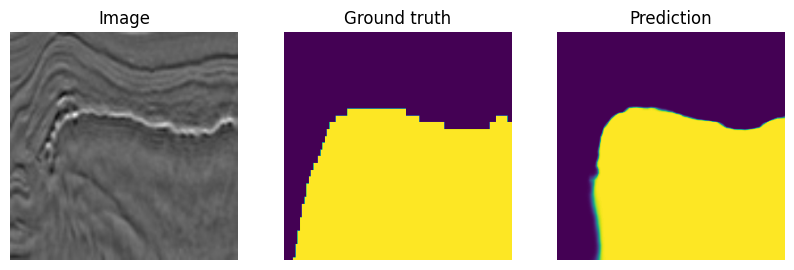

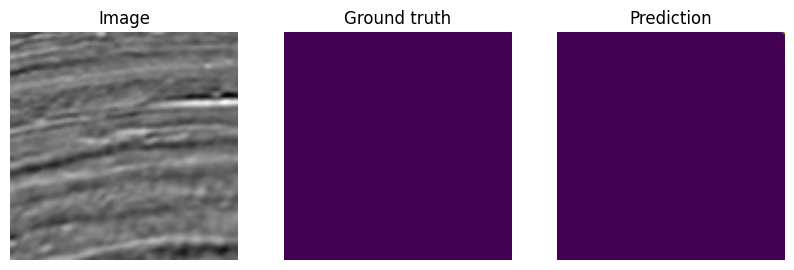

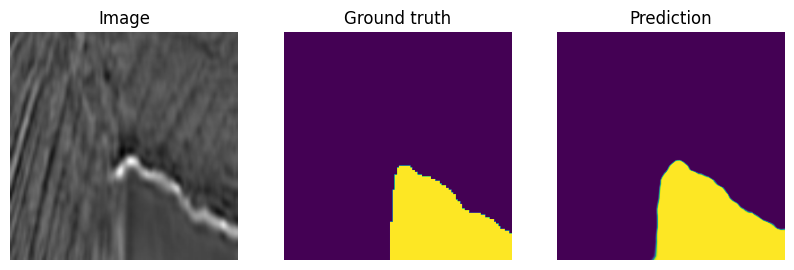

In [19]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
    
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

The end! This can surly be improved. Just wanted to show how a UNet could be used.